### import necessary package and module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



### prepare necessary materials 
* Fetch data set
* Standardization of data sets
* Build classifier(svm, decision tree)

In [2]:
iris = datasets.load_iris()
x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1,stratify=y)
sc = StandardScaler()

x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)
x_std = sc.fit_transform(x)

svm = SVC(kernel = 'rbf', gamma = 1, C = 1,probability = True)
tree = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)

### k-fold cross-validation

In [3]:
def k_fold(n_split,classifier,data,target):
    kfold = StratifiedKFold(n_split).split(data,target)
    scores = []

    for k,(train,test) in enumerate(kfold):
        classifier.fit(data[train],target[train])
        score = classifier.score(data[test],target[test])
        scores.append(score)
        print("Fold:{0}, class dist:{1},accuracy:{2:.3f}".format(k+1, np.bincount(target[train]),score))
    
    print("accuracy:{0:.3f} +- {1:.3f}\n".format(np.mean(scores),np.std(scores)))
    
#  k-fold cross-validation of svm
k_fold(10, svm, x_std,y)

#  k-fold cross-validation of decision tree
k_fold(10,tree,x_std,y)

Fold:1, class dist:[45 45 45],accuracy:1.000
Fold:2, class dist:[45 45 45],accuracy:0.933
Fold:3, class dist:[45 45 45],accuracy:1.000
Fold:4, class dist:[45 45 45],accuracy:0.933
Fold:5, class dist:[45 45 45],accuracy:0.933
Fold:6, class dist:[45 45 45],accuracy:0.933
Fold:7, class dist:[45 45 45],accuracy:0.867
Fold:8, class dist:[45 45 45],accuracy:1.000
Fold:9, class dist:[45 45 45],accuracy:0.933
Fold:10, class dist:[45 45 45],accuracy:1.000
accuracy:0.953 +- 0.043

Fold:1, class dist:[45 45 45],accuracy:1.000
Fold:2, class dist:[45 45 45],accuracy:0.933
Fold:3, class dist:[45 45 45],accuracy:1.000
Fold:4, class dist:[45 45 45],accuracy:0.933
Fold:5, class dist:[45 45 45],accuracy:0.933
Fold:6, class dist:[45 45 45],accuracy:0.933
Fold:7, class dist:[45 45 45],accuracy:0.933
Fold:8, class dist:[45 45 45],accuracy:0.933
Fold:9, class dist:[45 45 45],accuracy:1.000
Fold:10, class dist:[45 45 45],accuracy:1.000
accuracy:0.960 +- 0.033



### learning cruve

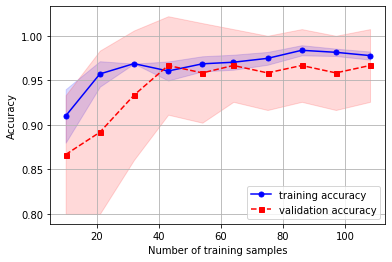

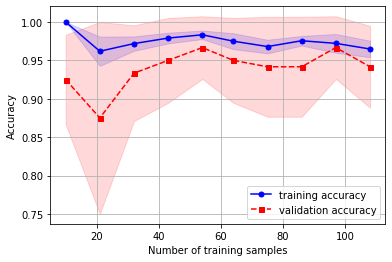

In [4]:
def draw_learn_cruve(classifier, data, target, fold = 10):
    train_sizes,train_scores,test_scores = learning_curve(estimator = classifier, X = data, y = target,
                                                     train_sizes = np.linspace(0.1,1.0,10),
                                                     cv = fold)
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores,axis = 1)
    test_mean = np.mean(test_scores,axis = 1)
    test_std = np.std(test_scores,axis =1)
    plt.plot(train_sizes,train_mean,color = 'blue',marker = 'o',markersize = 5, label = 'training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    plt.plot(train_sizes,test_mean,color = 'red',linestyle = '--',marker = 's',markersize = 5, label = 'validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,color = 'red', alpha = 0.15)
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.show()
    
# learn cruve of svm
draw_learn_cruve(classifier = svm, data = x_train, target = y_train)

# learn cruve of decision tree
draw_learn_cruve(classifier = tree, data = x_train, target = y_train)

### validation cruve

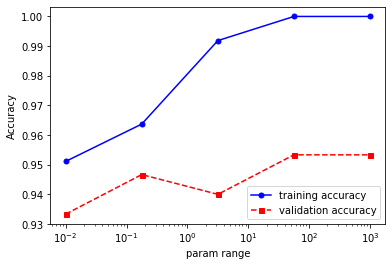

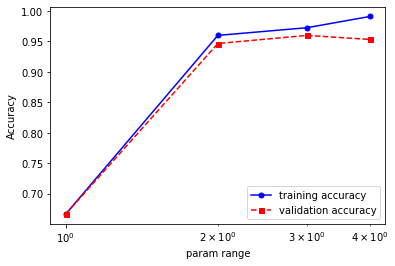

In [5]:

def draw_validation_line(classifier, data, target, param, param_range, fold = 10):
    train_scores, test_scores = validation_curve(estimator = classifier, X = data, y = target, param_name = param,
                                             param_range = param_range,cv = fold)
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores,axis = 1)
    test_mean = np.mean(test_scores,axis = 1)
    test_std = np.std(test_scores,axis =1)

    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores,axis = 1)
    test_mean = np.mean(test_scores,axis = 1)
    test_std = np.std(test_scores,axis =1)

    plt.plot(param_range,train_mean,color = 'blue',marker = 'o', markersize = 5, label = 'training accuracy')
    plt.plot(param_range,test_mean,color = 'red', linestyle = '--',marker = 's',markersize = 5, label = 'validation accuracy')
    plt.xscale('log')
    plt.legend(loc = 'lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('param range')
    plt.show()
    
# validation line of svm
draw_validation_line(svm, x_std, y, 'C',np.logspace(-2,3,5))

# validation line of decision tree
draw_validation_line(tree, x, y, 'max_depth',np.linspace(1,4,4))

### roc cruve

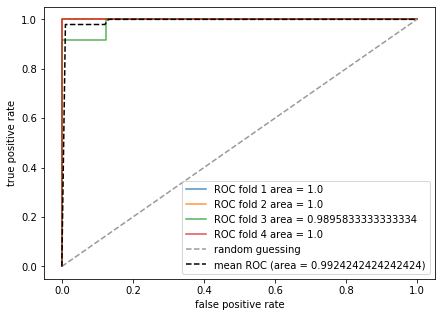

In [6]:
#关于多分类问题的ROC曲线参考了python机器学习这本书的部分代码

cv = StratifiedKFold(n_splits = 4).split(x,y)
fig = plt.figure(figsize = (7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for i, (train,test) in enumerate(cv):
    probas  = svm.fit(x[train],y[train]).predict_proba(x[test])
    fpr, tpr, thresholds = roc_curve(y[test],probas[:, 1],pos_label= 1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label = 'ROC fold {0} area = {1}'.format(i+1, roc_auc),alpha = 0.8)
    
plt.plot([0, 1],[0, 1],linestyle = '--', color = (0.6,0.6,0.6),label = 'random guessing')
mean_tpr /= 4
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k--',label = 'mean ROC (area = {})'.format(mean_auc))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc = 'lower right')

### gridsearch & nested cross validation

In [7]:
x_std = sc.fit_transform(x)
param_range = np.logspace(-2,2,5)
degree_range = np.linspace(0,4,4)
param_grid = [{"C":param_range, "kernel":['linear']},
             {"C":param_range, "kernel":['rbf'],"gamma":param_range},
             {"C":param_range, "kernel":['poly'],"degree":degree_range}]
grid = GridSearchCV(estimator = svm,param_grid = param_grid ,scoring = 'accuracy',cv = 10)
grid = grid.fit(x_train_std,y_train)
print(grid.best_score_)
print(grid.best_params_)


0.9666666666666667
{'C': 0.1, 'kernel': 'linear'}


In [8]:
grid = GridSearchCV(estimator = svm,param_grid = param_grid ,scoring = 'accuracy',cv = 5,n_jobs=3)
scores = cross_val_score(grid, x_std,y,scoring = 'accuracy',cv = 5)
print('CV accuracy = {0:.3f} +- {1:.3f}'.format(np.mean(scores),np.std(scores)))

CV accuracy = 0.960 +- 0.039


In [9]:
grid = GridSearchCV(estimator = tree, param_grid = {'max_depth':np.linspace(1,4,4)},cv =5 ,n_jobs = 3)
scores = cross_val_score(grid, x_std,y,scoring = 'accuracy',cv = 5)
print('tree accuracy = {0:.3f} +- {1:.3f}'.format(np.mean(scores),np.std(scores)))

tree accuracy = 0.960 +- 0.025


* svm is better than decision tree